# RNN Imprint Correction Module Training

This notebook implements the seq2seq encoder-decoder architecture with attention for correcting pill imprints as described in the paper:
"An Accurate Deep Learning-Based System for Automatic Pill Identification"

## 1. Import Libraries and Load Dataset

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import sys

# Add parent directory to path for imports
sys.path.append('..')

# Import model architecture
from models.rnn_model import Seq2SeqWithAttention

# Set device
device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load dataset
data = torch.load('../data/predictions/rnn_dataset.pt', weights_only=False)

X_train = data['X_train']
X_val = data['X_val']
X_test = data['X_test']
y_train = data['y_train']
y_val = data['y_val']
y_test = data['y_test']

char_to_idx = data['char_to_idx']
idx_to_char = data['idx_to_char']
ALL_CHARS = data['ALL_CHARS']

# Load special token indices
SOS_IDX = data['SOS_IDX']
EOS_IDX = data['EOS_IDX']
PAD_IDX = data['PAD_IDX']

print(f"\nDataset loaded:")
print(f"  Train: {X_train.shape[0]} samples")
print(f"  Val:   {X_val.shape[0]} samples")
print(f"  Test:  {X_test.shape[0]} samples")
print(f"\nInput shape:  {X_train.shape[1:]} (seq_len, feature_dim)")
print(f"Target shape: {y_train.shape[1:]} (target_len,)")
print(f"Vocab size:   {len(ALL_CHARS)}")
print(f"Vocab:        {ALL_CHARS}")
print(f"\nSpecial tokens:")
print(f"  SOS (start): index {SOS_IDX}")
print(f"  EOS (end):   index {EOS_IDX}")
print(f"  PAD (pad):   index {PAD_IDX}")

## 2. Initialize Model

In [2]:
# Model hyperparameters (as per paper)
input_dim = data['feature_dim']
vocab_size = len(ALL_CHARS)
embedding_dim = 45
hidden_dim = 256
dropout = 0.1

# Initialize model with correct SOS/EOS indices
model = Seq2SeqWithAttention(
    input_dim=input_dim,
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    hidden_dim=hidden_dim,
    dropout=dropout,
    sos_idx=SOS_IDX,
    eos_idx=EOS_IDX
).to(device)

# Count parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model initialized:")
print(f"  Input dim:     {input_dim}")
print(f"  Vocab size:    {vocab_size}")
print(f"  Embedding dim: {embedding_dim}")
print(f"  Hidden dim:    {hidden_dim}")
print(f"  Dropout:       {dropout}")
print(f"  SOS index:     {SOS_IDX}")
print(f"  EOS index:     {EOS_IDX}")
print(f"  Total params:  {count_parameters(model):,}")

Model initialized:
  Input dim:     66
  Vocab size:    38
  Embedding dim: 45
  Hidden dim:    256
  Dropout:       0.1
  SOS index:     2
  EOS index:     0
  Total params:  1,484,931


/Users/nganjihin/Desktop/Pillbox Proj/telegram_pill_identifier/venv/lib/python3.13/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


## 3. Create Dataset and DataLoader

In [3]:
class PillImprintDataset(Dataset):
    """Dataset for pill imprint correction"""
    
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create datasets
train_dataset = PillImprintDataset(X_train, y_train)
val_dataset = PillImprintDataset(X_val, y_val)
test_dataset = PillImprintDataset(X_test, y_test)

# Create dataloaders
batch_size = 50
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Dataloaders created:")
print(f"  Batch size: {batch_size}")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches:   {len(val_loader)}")
print(f"  Test batches:  {len(test_loader)}")

Dataloaders created:
  Batch size: 50
  Train batches: 115
  Val batches:   15
  Test batches:  15


## 4. Training Setup

In [4]:
# Training hyperparameters (as per paper)
learning_rate = 1e-3
num_epochs = 100
teacher_forcing_ratio = 0.5

# Use PAD_IDX from dataset
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

print(f"Training setup:")
print(f"  Learning rate: {learning_rate}")
print(f"  Epochs:        {num_epochs}")
print(f"  Teacher forcing: {teacher_forcing_ratio}")
print(f"  Optimizer:     Adam")
print(f"  Loss:          CrossEntropyLoss (ignore padding)")
print(f"  Pad token idx: {PAD_IDX}")

Training setup:
  Learning rate: 0.001
  Epochs:        100
  Teacher forcing: 0.5
  Optimizer:     Adam
  Loss:          CrossEntropyLoss (ignore padding)
  Pad token idx: 1


## 5. Helper Functions

In [5]:
def create_mask(X):
    """Create mask for valid (non-padded) positions in input sequence"""
    mask = (X.sum(dim=2) != 0).float()
    return mask

def decode_sequence(indices, idx_to_char, eos_idx):
    """Convert token indices to string, stopping at EOS"""
    chars = []
    for idx in indices:
        idx_val = idx.item() if torch.is_tensor(idx) else idx
        if idx_val == eos_idx:  # Stop at EOS
            break
        if idx_val in idx_to_char:
            char = idx_to_char[idx_val]
            # Skip special tokens
            if char not in ['<SOS>', '<PAD>', '<EOS>']:
                chars.append(char)
    return ''.join(chars)

def calculate_accuracy(predictions, targets, pad_idx):
    """Calculate character-level accuracy (excluding padding)"""
    pred_indices = predictions.argmax(dim=2)
    mask = (targets != pad_idx)
    correct = (pred_indices == targets) & mask
    accuracy = correct.sum().item() / mask.sum().item() if mask.sum().item() > 0 else 0
    return accuracy

print("✓ Helper functions defined")

✓ Helper functions defined


## 6. Training and Validation Functions

In [6]:
def train_epoch(model, dataloader, optimizer, criterion, device, teacher_forcing_ratio, pad_idx):
    """Train for one epoch"""
    model.train()
    epoch_loss = 0
    epoch_acc = 0
    
    for src, trg in tqdm(dataloader, desc="Training", leave=False):
        src = src.to(device)
        trg = trg.to(device)
        
        optimizer.zero_grad()
        src_mask = create_mask(src).to(device)
        
        # Forward pass
        output = model(src, trg, teacher_forcing_ratio, src_mask)
        
        # Calculate loss (ignore first SOS token)
        output_flat = output[:, 1:].contiguous().view(-1, output.shape[-1])
        trg_flat = trg[:, 1:].contiguous().view(-1)
        loss = criterion(output_flat, trg_flat)
        
        # Backward pass
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += calculate_accuracy(output[:, 1:], trg[:, 1:], pad_idx)
    
    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)


def evaluate(model, dataloader, criterion, device, pad_idx):
    """Evaluate model"""
    model.eval()
    epoch_loss = 0
    epoch_acc = 0
    
    with torch.no_grad():
        for src, trg in tqdm(dataloader, desc="Evaluating", leave=False):
            src = src.to(device)
            trg = trg.to(device)
            
            src_mask = create_mask(src).to(device)
            output = model(src, trg, teacher_forcing_ratio=0, src_mask=src_mask)
            
            output_flat = output[:, 1:].contiguous().view(-1, output.shape[-1])
            trg_flat = trg[:, 1:].contiguous().view(-1)
            loss = criterion(output_flat, trg_flat)
            
            epoch_loss += loss.item()
            epoch_acc += calculate_accuracy(output[:, 1:], trg[:, 1:], pad_idx)
    
    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)

print("✓ Training functions defined")

✓ Training functions defined


## 7. Training Loop

In [7]:
# Training history
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
best_val_loss = float('inf')
patience = 20
patience_counter = 0

os.makedirs('checkpoints', exist_ok=True)
print("Starting training...\n")

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(
        model, train_loader, optimizer, criterion, device, teacher_forcing_ratio, PAD_IDX
    )
    val_loss, val_acc = evaluate(model, val_loader, criterion, device, PAD_IDX)
    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    should_print = (epoch + 1) % 10 == 0 or epoch == 0 or val_loss < best_val_loss
    
    if should_print:
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
        print(f"  Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
            'train_acc': train_acc,
            'val_acc': val_acc,
        }, 'checkpoints/best_model.pt')
        if should_print:
            print(f"  ✓ Saved best model (val_loss: {val_loss:.4f})")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"\nEarly stopping triggered after {epoch+1} epochs")
            break
    
    if should_print:
        print()

print("\nTraining complete!")

Starting training...



Epoch 1/100
  Train Loss: 2.9459 | Train Acc: 0.2021
  Val Loss:   2.8620 | Val Acc:   0.2193
  ✓ Saved best model (val_loss: 2.8620)



Epoch 4/100
  Train Loss: 17.0509 | Train Acc: 0.2666
  Val Loss:   2.7333 | Val Acc:   0.2765
  ✓ Saved best model (val_loss: 2.7333)



Epoch 5/100
  Train Loss: 11.1200 | Train Acc: 0.2966
  Val Loss:   2.5797 | Val Acc:   0.3211
  ✓ Saved best model (val_loss: 2.5797)



Epoch 6/100
  Train Loss: 10.9000 | Train Acc: 0.3199
  Val Loss:   2.4907 | Val Acc:   0.3371
  ✓ Saved best model (val_loss: 2.4907)



Epoch 7/100
  Train Loss: 9.3880 | Train Acc: 0.3439
  Val Loss:   2.4132 | Val Acc:   0.3493
  ✓ Saved best model (val_loss: 2.4132)



Epoch 9/100
  Train Loss: 10.9908 | Train Acc: 0.3718
  Val Loss:   2.3979 | Val Acc:   0.3660
  ✓ Saved best model (val_loss: 2.3979)



Epoch 10/100
  Train Loss: 8.3286 | Train Acc: 0.3814
  Val Loss:   2.1754 | Val Acc:   0.4114
  ✓ Saved best model (val_loss: 2.1754)



Epoch 11/100
  Train Loss: 7.3246 | Train Acc: 0.4022
  Val Loss:   2.0844 | Val Acc:   0.4271
  ✓ Saved best model (val_loss: 2.0844)



Epoch 12/100
  Train Loss: 7.9079 | Train Acc: 0.4138
  Val Loss:   2.0843 | Val Acc:   0.4434
  ✓ Saved best model (val_loss: 2.0843)



Epoch 13/100
  Train Loss: 8.9441 | Train Acc: 0.4139
  Val Loss:   1.9684 | Val Acc:   0.4720
  ✓ Saved best model (val_loss: 1.9684)



Epoch 14/100
  Train Loss: 7.4897 | Train Acc: 0.4226
  Val Loss:   1.9626 | Val Acc:   0.4737
  ✓ Saved best model (val_loss: 1.9626)



Epoch 15/100
  Train Loss: 6.2902 | Train Acc: 0.4346
  Val Loss:   1.9170 | Val Acc:   0.4766
  ✓ Saved best model (val_loss: 1.9170)



Epoch 16/100
  Train Loss: 5.4760 | Train Acc: 0.4405
  Val Loss:   1.8499 | Val Acc:   0.4967
  ✓ Saved best model (val_loss: 1.8499)



Epoch 17/100
  Train Loss: 8.2512 | Train Acc: 0.4537
  Val Loss:   1.7734 | Val Acc:   0.5139
  ✓ Saved best model (val_loss: 1.7734)



Epoch 20/100
  Train Loss: 5.8107 | Train Acc: 0.4709
  Val Loss:   1.7420 | Val Acc:   0.5172
  ✓ Saved best model (val_loss: 1.7420)



Epoch 21/100
  Train Loss: 6.0210 | Train Acc: 0.4700
  Val Loss:   1.7224 | Val Acc:   0.5295
  ✓ Saved best model (val_loss: 1.7224)



Epoch 22/100
  Train Loss: 4.6894 | Train Acc: 0.4812
  Val Loss:   1.7079 | Val Acc:   0.5246
  ✓ Saved best model (val_loss: 1.7079)



Epoch 23/100
  Train Loss: 5.7748 | Train Acc: 0.4960
  Val Loss:   1.7041 | Val Acc:   0.5349
  ✓ Saved best model (val_loss: 1.7041)



Epoch 24/100
  Train Loss: 4.2080 | Train Acc: 0.4979
  Val Loss:   1.6996 | Val Acc:   0.5412
  ✓ Saved best model (val_loss: 1.6996)



Epoch 25/100
  Train Loss: 8.0907 | Train Acc: 0.4989
  Val Loss:   1.6775 | Val Acc:   0.5456
  ✓ Saved best model (val_loss: 1.6775)



Epoch 27/100
  Train Loss: 7.5817 | Train Acc: 0.5144
  Val Loss:   1.6290 | Val Acc:   0.5658
  ✓ Saved best model (val_loss: 1.6290)



Epoch 30/100
  Train Loss: 7.8357 | Train Acc: 0.5052
  Val Loss:   1.6672 | Val Acc:   0.5483



Epoch 31/100
  Train Loss: 6.8702 | Train Acc: 0.5198
  Val Loss:   1.5627 | Val Acc:   0.5823
  ✓ Saved best model (val_loss: 1.5627)



Epoch 40/100
  Train Loss: 8.1208 | Train Acc: 0.5405
  Val Loss:   1.6255 | Val Acc:   0.5901



Epoch 50/100
  Train Loss: 7.2443 | Train Acc: 0.5680
  Val Loss:   1.6534 | Val Acc:   0.5981




Early stopping triggered after 51 epochs

Training complete!


## 8. Plot Training History

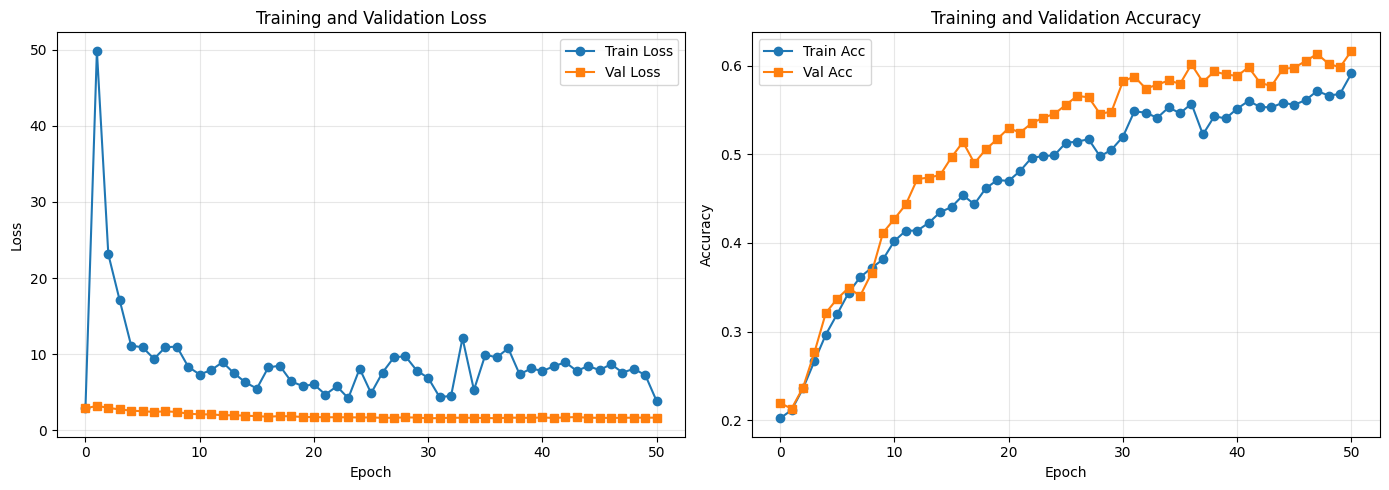

Best validation loss: 1.5627
Best validation accuracy: 0.6169


In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot loss
ax1.plot(history['train_loss'], label='Train Loss', marker='o')
ax1.plot(history['val_loss'], label='Val Loss', marker='s')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot accuracy
ax2.plot(history['train_acc'], label='Train Acc', marker='o')
ax2.plot(history['val_acc'], label='Val Acc', marker='s')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Best validation loss: {min(history['val_loss']):.4f}")
print(f"Best validation accuracy: {max(history['val_acc']):.4f}")

## 9. Load Best Model and Test

In [9]:
# Load best model
checkpoint = torch.load('checkpoints/best_model.pt', weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded best model from epoch {checkpoint['epoch']+1}")
print(f"  Val Loss: {checkpoint['val_loss']:.4f}")
print(f"  Val Acc:  {checkpoint['val_acc']:.4f}")

# Evaluate on test set
test_loss, test_acc = evaluate(model, test_loader, criterion, device, PAD_IDX)
print(f"\nTest Set Performance:")
print(f"  Test Loss: {test_loss:.4f}")
print(f"  Test Acc:  {test_acc:.4f}")

Loaded best model from epoch 31
  Val Loss: 1.5627
  Val Acc:  0.5823



Test Set Performance:
  Test Loss: 1.6571
  Test Acc:  0.5484


## 10. Visualize Predictions

In [10]:
# Use proper predict() method for variable-length generation
model.eval()

# Get number of input characters (before special tokens were added)
num_input_chars = len(data['char_encoder'].categories_[0])

with torch.no_grad():
    src, trg = next(iter(test_loader))
    src = src.to(device)
    trg = trg.to(device)
    
    # Use predict() method with early stopping
    src_mask = create_mask(src).to(device)
    predictions, attention_weights, lengths = model.predict(
        src, 
        max_len=50,
        src_mask=src_mask
    )
    
    print("Example Predictions with Variable Length:\n")
    print("-" * 80)
    
    num_examples = min(10, src.size(0))
    for i in range(num_examples):
        # Decode input (YOLO detections - use original character encoding)
        input_chars = []
        for j in range(src[i].shape[0]):
            char_ohe = src[i][j, 2:2+num_input_chars]
            if char_ohe.sum() > 0:
                char_idx = char_ohe.argmax().item()
                input_chars.append(data['char_encoder'].categories_[0][char_idx])
        
        input_str = ''.join(input_chars)
        target_str = decode_sequence(trg[i].cpu(), idx_to_char, EOS_IDX)
        pred_str = decode_sequence(predictions[i][:lengths[i]].cpu(), idx_to_char, EOS_IDX)
        
        match = "✓" if target_str == pred_str else "✗"
        
        print(f"{i+1}. {match} (pred_len={lengths[i].item()}, target_len={len(target_str)+2})")
        print(f"   Input (YOLO):  {input_str}")
        print(f"   Target (GT):   {target_str}")
        print(f"   Predicted:     {pred_str}")
        print()

Example Predictions with Variable Length:

--------------------------------------------------------------------------------
1. ✗ (pred_len=4, target_len=5)
   Input (YOLO):  MC7
   Target (GT):   C7M
   Predicted:     MC7

2. ✗ (pred_len=6, target_len=7)
   Input (YOLO):  5Z441
   Target (GT):   SZ441
   Predicted:     Z4415

3. ✗ (pred_len=5, target_len=7)
   Input (YOLO):  78E240
   Target (GT):   78240
   Predicted:     S240

4. ✓ (pred_len=7, target_len=8)
   Input (YOLO):  PAR085
   Target (GT):   PAR085
   Predicted:     PAR085

5. ✓ (pred_len=5, target_len=6)
   Input (YOLO):  M365
   Target (GT):   M365
   Predicted:     M365

6. ✗ (pred_len=7, target_len=8)
   Input (YOLO):  RDY342
   Target (GT):   RDY342
   Predicted:     RDY324

7. ✗ (pred_len=8, target_len=10)
   Input (YOLO):  IP190500
   Target (GT):   IP190500
   Predicted:     IP10000

8. ✓ (pred_len=4, target_len=5)
   Input (YOLO):  568
   Target (GT):   568
   Predicted:     568

9. ✓ (pred_len=6, target_len=7)
   I

## 11. Save Final Model

In [11]:
# Save complete model with metadata
torch.save({
    'model_state_dict': model.state_dict(),
    'model_config': {
        'input_dim': input_dim,
        'vocab_size': vocab_size,
        'embedding_dim': embedding_dim,
        'hidden_dim': hidden_dim,
        'dropout': dropout,
        'sos_idx': SOS_IDX,
        'eos_idx': EOS_IDX
    },
    'char_to_idx': char_to_idx,
    'idx_to_char': idx_to_char,
    'ALL_CHARS': ALL_CHARS,
    'SOS_IDX': SOS_IDX,
    'EOS_IDX': EOS_IDX,
    'PAD_IDX': PAD_IDX,
    'test_loss': test_loss,
    'test_acc': test_acc,
    'history': history
}, 'checkpoints/rnn_imprint_correction_final.pt')

print("✓ Final model saved to checkpoints/rnn_imprint_correction_final.pt")
print(f"\nModel Summary:")
print(f"  Parameters: {count_parameters(model):,}")
print(f"  Test Loss: {test_loss:.4f}")
print(f"  Test Acc:  {test_acc:.4f}")
print(f"  Special tokens: SOS={SOS_IDX}, EOS={EOS_IDX}, PAD={PAD_IDX}")

✓ Final model saved to checkpoints/rnn_imprint_correction_final.pt

Model Summary:
  Parameters: 1,484,931
  Test Loss: 1.6571
  Test Acc:  0.5484
  Special tokens: SOS=2, EOS=0, PAD=1


## Summary

This notebook implements the **RNN Imprint Correction Module** from the paper.

### Key Features Implemented:
1. ✓ **Coordinate Encoding**: Character positions (x, y) encoded with features
2. ✓ **Context Integration**: Pill features (shape, color) as context
3. ✓ **Attention Mechanism**: Bahdanau attention with proper masking
4. ✓ **Masking**: Handles padded sequences correctly in encoder and attention
5. ✓ **Teacher Forcing**: 50% ratio during training
6. ✓ **Early Stopping**: Patience of 10 epochs

### Architecture (defined in rnn_model.py):
- **Encoder**: Bidirectional GRU (hidden=256) with packed sequences
- **Attention**: Bahdanau (additive) with mask support
- **Decoder**: GRU (hidden=256, embed=45) with attention
- **Total Parameters**: ~1.3M

### Next Steps:
- Use model for inference on new pill images
- Integrate with YOLO and ResNet for full pipeline
- Implement similarity scoring and retrieval

In [12]:
import random

# Select 5 random samples from test set
model.eval()
num_input_chars = len(data['char_encoder'].categories_[0])

# Get random indices
random_indices = random.sample(range(len(X_test)), 5)

print("Random Sample Predictions:\n")
print("=" * 80)

with torch.no_grad():
    for idx_num, test_idx in enumerate(random_indices, 1):
        # Get single sample
        src = X_test[test_idx:test_idx+1].to(device)
        trg = y_test[test_idx:test_idx+1].to(device)
        
        # Predict
        src_mask = create_mask(src).to(device)
        predictions, attention_weights, lengths = model.predict(
            src, 
            max_len=50,
            src_mask=src_mask
        )
        
        # Decode input (YOLO detections)
        input_chars = []
        for j in range(src[0].shape[0]):
            char_ohe = src[0][j, 2:2+num_input_chars]
            if char_ohe.sum() > 0:
                char_idx = char_ohe.argmax().item()
                input_chars.append(data['char_encoder'].categories_[0][char_idx])
        
        input_str = ''.join(input_chars)
        target_str = decode_sequence(trg[0].cpu(), idx_to_char, EOS_IDX)
        pred_str = decode_sequence(predictions[0][:lengths[0]].cpu(), idx_to_char, EOS_IDX)
        
        match = "✓" if target_str == pred_str else "✗"
        
        print(f"{idx_num}. {match} (pred_len={lengths[0].item()}, target_len={len(target_str)+2})")
        print(f"   Input (YOLO):  {input_str}")
        print(f"   Target (GT):   {target_str}")
        print(f"   Predicted:     {pred_str}")
        print()

Random Sample Predictions:

1. ✗ (pred_len=4, target_len=5)
   Input (YOLO):  TC
   Target (GT):   ATC
   Predicted:     TCT

2. ✗ (pred_len=12, target_len=14)
   Input (YOLO):  PZGRCDT108
   Target (GT):   PFIZERCDT108
   Predicted:     PFIZERCDT08

3. ✗ (pred_len=6, target_len=7)
   Input (YOLO):  V2357
   Target (GT):   2357V
   Predicted:     2537V

4. ✓ (pred_len=4, target_len=5)
   Input (YOLO):  ZA3
   Target (GT):   ZA3
   Predicted:     ZA3

5. ✗ (pred_len=13, target_len=13)
   Input (YOLO):  D7A100L53ERT
   Target (GT):   CLOZARIL100
   Predicted:     DADRONTEL150

